In [1]:
from preamble import *
%matplotlib inline
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
!pip install watermark

In [4]:
%load_ext watermark
%watermark -v -p sklearn,numpy,scipy,matplotlib

CPython 3.6.12
IPython 7.16.1

sklearn 0.24.1
numpy 1.19.5
scipy 1.5.4
matplotlib 3.3.4


In [5]:
import sys
print("Python 버전 : ", sys.version)

import pandas as pd
print("pandas 버전 : ", pd.__version__)

import matplotlib
print("matplotlib 버전 : ", matplotlib.__version__)

import numpy as np
print("NumPy 버전 : ", np.__version__)

import scipy as sp
print("SciPy 버전 : ", sp.__version__)

import IPython
print("IPython 버전 : ", IPython.__version__)

import sklearn
print("scikit-learn 버전 : ", sklearn.__version__)

Python 버전 :  3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
pandas 버전 :  1.1.5
matplotlib 버전 :  3.3.4
NumPy 버전 :  1.19.2
SciPy 버전 :  1.5.2
IPython 버전 :  7.16.1
scikit-learn 버전 :  0.24.1


In [7]:
import os

data = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_PATH, "adult.data"), header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [8]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


# 범주형데이터 자동변환

In [9]:
data_dummies = pd.get_dummies(data)

# 타겟값 제외
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']

# NumPy 배열 추출
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44)  y.shape: (32561,)


# 로지스틱회귀

In [14]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(logreg.score(X_test, y_test)))

테스트 점수: 0.81


# 숫자로 표현된 범주형 특성

In [15]:
# 숫자 특성과 범주형 문자열 특성을 가진 DataFrame생성
demo_df = pd.DataFrame({'숫자 특성': [0, 1, 2, 1],
                        '범주형 특성': ['양말', '여우', '양말', '상자']})
display(demo_df)

,숫자 특성,범주형 특성
0,0,양말
1,1,여우
2,2,양말
3,1,상자


In [16]:
display(pd.get_dummies(demo_df))

,숫자 특성,범주형 특성_상자,범주형 특성_양말,범주형 특성_여우
0,0,0,1,0
1,1,0,0,1
2,2,0,1,0
3,1,1,0,0


In [17]:
demo_df['숫자 특성'] = demo_df['숫자 특성'].astype(str)
display(pd.get_dummies(demo_df, columns=['숫자 특성', '범주형 특성']))

,숫자 특성_0,숫자 특성_1,숫자 특성_2,범주형 특성_상자,범주형 특성_양말,범주형 특성_여우
0,1,0,0,0,1,0
1,0,1,0,0,0,1
2,0,0,1,0,1,0
3,0,1,0,1,0,0


# OneHotEncoder와 ColumnTransformer

In [20]:
from sklearn.preprocessing import OneHotEncoder
# sparse=False로 설정하면 OneHotEncode가 희소 행렬이 아니라 넘파이 배열을 반환합니다
ohe = OneHotEncoder(sparse=False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0.]]


In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer(
    [("scaling", StandardScaler(), ['age', 'hours-per-week']),
     ("onehot", OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])])

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# income을 제외한 모든 열을 추출합니다
data_features = data.drop("income", axis=1)
# 데이터프레임과 income을 분할합니다
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data.income, random_state=0)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(24420, 44)


In [23]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
print("테스트 점수: {:.2f}".format(logreg.score(X_test_trans, y_test)))

테스트 점수: 0.81


In [26]:
# ColumnTransformer 안의 단계 접근시 named_transformers_ 속성 사용
print(ct.named_transformers_.onehot)
print(ct.named_transformers_.scaling)

OneHotEncoder(sparse=False)
StandardScaler()


# Make_column_transformer

In [27]:
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
    (StandardScaler(), ['age', 'hours-per-week']),
    (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation']))

In [64]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

column_trans = make_column_transformer(
    (OneHotEncoder(), ['city']),
    (CountVectorizer(), 'title'),
    remainder=MinMaxScaler())
column_trans

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])

# 구간분할

DecisionTreeRegression score : 0.86
Linear Regression score : 0.63


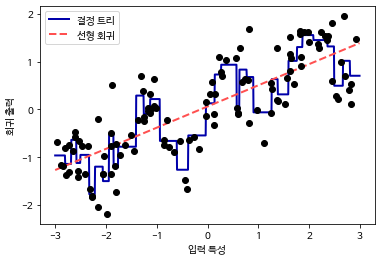

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

dreg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, dreg.predict(line), label="결정 트리")

lreg = LinearRegression().fit(X, y)
plt.plot(line, lreg.predict(line), '--', label="선형 회귀")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")
print("DecisionTreeRegression score : {:.2f}".format(dreg.score(X, y)))
print("Linear Regression score : {:.2f}".format(lreg.score(X, y)))

In [37]:
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.967, -2.378, -1.789, -1.2  , -0.612, -0.023,  0.566,  1.155,
        1.744,  2.333,  2.921])]


In [38]:
print(X[:10])
X_binned[:10]

[[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]
 [-2.064]
 [-2.651]
 [ 2.197]
 [ 0.607]
 [ 1.248]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

DecisionTreeRegression score : 0.72
Linear Regression score : 0.72


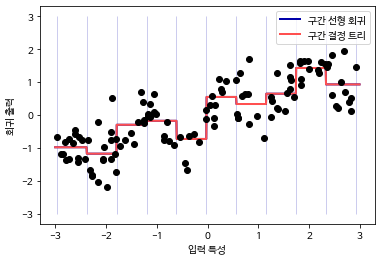

In [46]:
line_binned = kb.transform(line)

lreg = LinearRegression().fit(X_binned, y)
plt.plot(line, lreg.predict(line_binned), label='구간 선형 회귀')

dreg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, dreg.predict(line_binned), label='구간 결정 트리')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")

print("DecisionTreeRegression score : {:.2f}".format(dreg.score(X_binned, y)))
print("Linear Regression score : {:.2f}".format(lreg.score(X_binned, y)))

# 원본 추가

In [40]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)
print(X_combined[:5])

(120, 11)
[[-0.753  0.     0.     0.     1.     0.     0.     0.     0.     0.
   0.   ]
 [ 2.704  0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.   ]
 [ 1.392  0.     0.     0.     0.     0.     0.     0.     1.     0.
   0.   ]
 [ 0.592  0.     0.     0.     0.     0.     0.     1.     0.     0.
   0.   ]
 [-2.064  0.     1.     0.     0.     0.     0.     0.     0.     0.
   0.   ]]


DecisionTreeRegression score : 0.99
Linear Regression score : 0.73


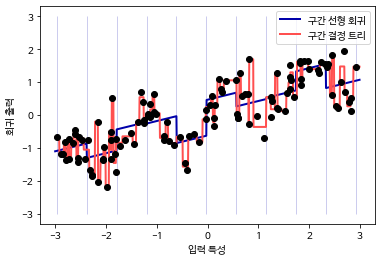

In [47]:
line_combined = np.hstack([line, line_binned])

lreg = LinearRegression().fit(X_combined, y)
plt.plot(line, lreg.predict(line_combined), label='구간 선형 회귀')

dreg = DecisionTreeRegressor(min_samples_split=3).fit(X_combined, y)
plt.plot(line, dreg.predict(line_combined), label='구간 결정 트리')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")

print("DecisionTreeRegression score : {:.2f}".format(dreg.score(X_combined, y)))
print("Linear Regression score : {:.2f}".format(lreg.score(X_combined, y)))

# 원본과의 곱 추가

In [50]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)
print(X_product[:5])

(120, 20)
[[ 0.     0.     0.     1.     0.     0.     0.     0.     0.     0.
  -0.    -0.    -0.    -0.753 -0.    -0.    -0.    -0.    -0.    -0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     2.704]
 [ 0.     0.     0.     0.     0.     0.     0.     1.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     1.392  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.592  0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.    -2.064 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]]


DecisionTreeRegression score : 0.99
Linear Regression score : 0.79


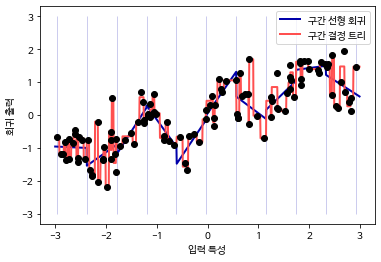

In [49]:
line_product = np.hstack([line_binned, line * line_binned])

lreg = LinearRegression().fit(X_product, y)
plt.plot(line, lreg.predict(line_product), label='구간 선형 회귀')

dreg = DecisionTreeRegressor(min_samples_split=3).fit(X_product, y)
plt.plot(line, dreg.predict(line_product), label='구간 결정 트리')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")

print("DecisionTreeRegression score : {:.2f}".format(dreg.score(X_product, y)))
print("Linear Regression score : {:.2f}".format(lreg.score(X_product, y)))

# 다항식 추가

In [52]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
print("X_poly.shape:", X_poly.shape)
print("X 원소:\n", X[:5])
print("X_poly 원소:\n", X_poly[:5])
print("항 이름:\n", poly.get_feature_names())

X_poly.shape: (120, 10)
X 원소:
 [[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]
X_poly 원소:
 [[   -0.753     0.567    -0.427     0.321    -0.242     0.182    -0.137
      0.103    -0.078     0.058]
 [    2.704     7.313    19.777    53.482   144.632   391.125  1057.714
   2860.36   7735.232 20918.278]
 [    1.392     1.938     2.697     3.754     5.226     7.274    10.125
     14.094    19.618    27.307]
 [    0.592     0.35      0.207     0.123     0.073     0.043     0.025
      0.015     0.009     0.005]
 [   -2.064     4.26     -8.791    18.144   -37.448    77.289  -159.516
    329.222  -679.478  1402.367]]
항 이름:
 ['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


Linear Regression score : 0.73


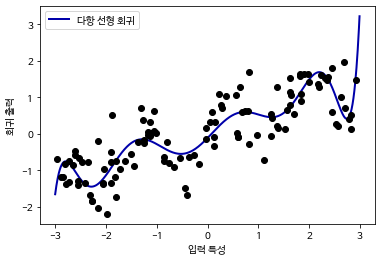

In [53]:
lreg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, lreg.predict(line_poly), label='다항 선형 회귀')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")

print("Linear Regression score : {:.2f}".format(lreg.score(X_poly, y)))

SVR gamma = 1 score : 0.75
SVR gamma = 10 score : 0.79


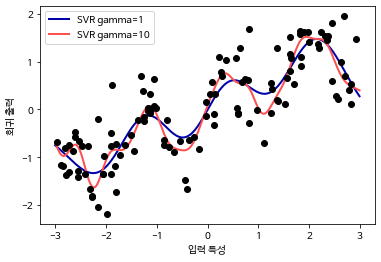

In [54]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))
    print("SVR gamma = {} score : {:.2f}".format(gamma, svr.score(X, y)))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("회귀 출력")
plt.xlabel("입력 특성")
plt.legend(loc="best")

In [55]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

# 데이터 스케일 조정
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape:", X_train.shape)
print("X_train_poly.shape:", X_train_poly.shape)
print("다항 특성 이름:\n", poly.get_feature_names())

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)
다항 특성 이름:
 ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


In [58]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train_scaled, y_train)
print("상호작용 특성이 없을 때 점수: {:.3f}".format(ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("상호작용 특성이 있을 때 점수: {:.3f}".format(ridge.score(X_test_poly, y_test)))

상호작용 특성이 없을 때 점수: 0.621
상호작용 특성이 있을 때 점수: 0.753


In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_scaled, y_train)
print("상호작용 특성이 없을 때 점수: {:.3f}".format(rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_poly, y_train)
print("상호작용 특성이 있을 때 점수: {:.3f}".format(rf.score(X_test_poly, y_test)))

상호작용 특성이 없을 때 점수: 0.795
상호작용 특성이 있을 때 점수: 0.775


# 데이터 변환

In [4]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

# 포아송 분포 데이터 생성
X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)
print(X_org[:50, 0])
print(X[:50, 0])

[ 1.764  2.241  0.95   0.411  0.761  0.334  0.313  0.654  2.27  -0.187
  0.155 -1.981  1.23  -0.302 -1.706 -0.438 -1.614  0.387 -0.028  0.302
 -0.672 -1.726 -1.63   0.052  1.139 -0.685 -0.312  0.901  1.488 -0.18
 -0.403  0.977  0.011  0.402 -1.27   1.944  1.923  0.906 -0.268 -0.155
  0.376  1.326 -0.435  0.407 -0.674  0.676  0.396  0.439  2.383  1.117]
[ 56  81  25  20  27  18  12  21 109   7  15   1  27   4   1   7   2  11
   6  18   1   2   2   7  31   7   7  28  37   9   8  21   7  20   3  71
  69  27   9   7  12  43   9  18   4  21  16  12 120  33]


In [5]:
print("특성 출현 횟수:\n", np.bincount(X[:, 0]))

특성 출현 횟수:
 [28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


In [8]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("테스트 점수: {:.3f}".format(score))

테스트 점수: 0.622


In [9]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("테스트 점수: {:.3f}".format(score))

테스트 점수: 0.875


# SelectPercentile

In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif

cancer = load_breast_cancer()

# 고정된 난수를 발생시킵니다
rng = np.random.RandomState(13)
noise = rng.normal(size=(len(cancer.data), 50))
# 데이터에 노이즈 특성을 추가합니다
# 처음 30개는 원본 특성이고 다음 50개는 노이즈입니다
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# f_classif(기본값)와 SelectPercentile을 사용하여 특성의 50%를 선택합니다
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
# 훈련 세트에 적용합니다
X_train_selected = select.transform(X_train)

print("X_train.shape:", X_train.shape)
print("X_train_selected.shape:", X_train_selected.shape)

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


In [19]:
from sklearn.linear_model import LogisticRegression

# 테스트 데이터 변환
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print("전체 특성을 사용한 점수: {:.3f}".format(lr.score(X_test, y_test)))
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_selected, y_train)
print("선택된 일부 특성을 사용한 점수: {:.3f}".format(
        lr.score(X_test_selected, y_test)))

전체 특성을 사용한 점수: 0.940
선택된 일부 특성을 사용한 점수: 0.937


# SelectFromModel

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape:", X_train.shape)
print("X_train_l1.shape:", X_train_l1.shape)

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


In [21]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train, y_train).score(X_test, y_test)
print("전체 특성을 사용한 점수: {:.3f}".format(score))
score = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("선택된 일부 특성을 사용한 점수: {:.3f}".format(score))

전체 특성을 사용한 점수: 0.940
선택된 일부 특성을 사용한 점수: 0.940


# RFE(Recursive feature elimination)

In [22]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=5000).fit(X_train, y_train).score(X_test, y_test)
print("전체 특성을 사용한 점수: {:.3f}".format(score))
score = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("선택된 일부 특성을 사용한 점수: {:.3f}".format(score))

전체 특성을 사용한 점수: 0.940
선택된 일부 특성을 사용한 점수: 0.947


# citibike

In [24]:
citibike = mglearn.datasets.load_citibike()
print("시티 바이크 데이터:\n", citibike.head())

시티 바이크 데이터:
 starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


In [25]:
# 타깃값 추출 (대여 횟수)
y = citibike.values
# 날짜와 시간을 하나의 숫자로 표현
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [30]:
# 처음 184개 데이터 포인트를 훈련 세트로 사용하고 나머지는 테스트 세트로 사용합니다
n_train = 184

# 주어진 특성을 사용하여 평가하고 그래프를 만듭니다
def eval_on_features(features, target, regressor):
    # 훈련 세트와 테스트 세트로 나눕니다
    X_train, X_test = features[:n_train], features[n_train:]
    # 타깃값도 나눕니다
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("테스트 세트 R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))
    xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
    week = ["일", "월", "화","수", "목", "금", "토"]
    xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime("%w"), 
                                                  xticks.strftime(" %m-%d"))]
    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="훈련")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="테스트")
    plt.plot(range(n_train), y_pred_train, '--', label="훈련 예측")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="테스트 예측")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("날짜")
    plt.ylabel("대여횟수")

테스트 세트 R^2: -0.04


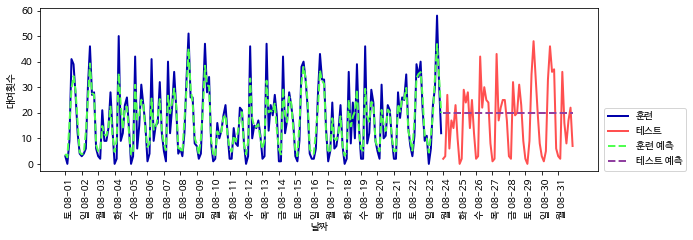

In [31]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

테스트 세트 R^2: 0.60


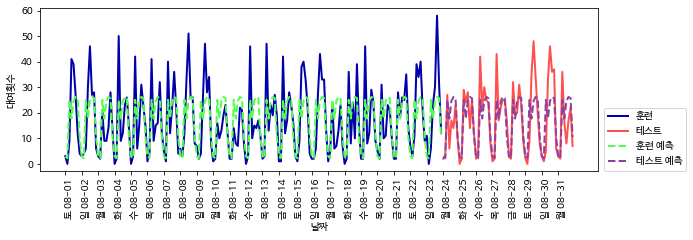

In [32]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

테스트 세트 R^2: 0.84


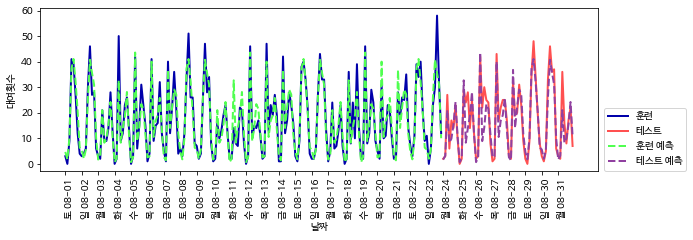

In [33]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

테스트 세트 R^2: 0.13


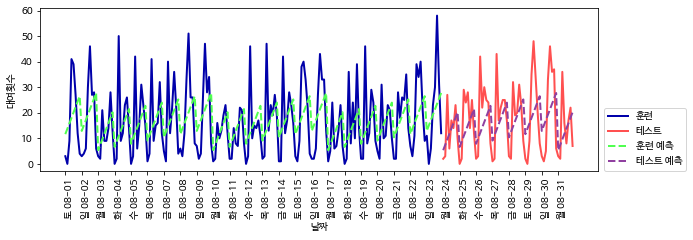

In [34]:
from sklearn.linear_model import LinearRegression

eval_on_features(X_hour_week, y, LinearRegression())

테스트 세트 R^2: 0.62


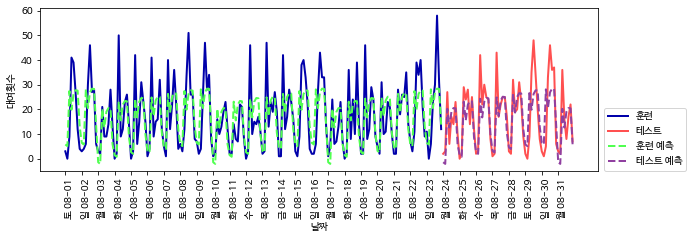

In [36]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, Ridge())

테스트 세트 R^2: 0.85


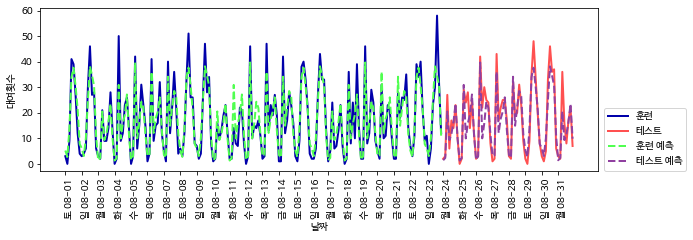

In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

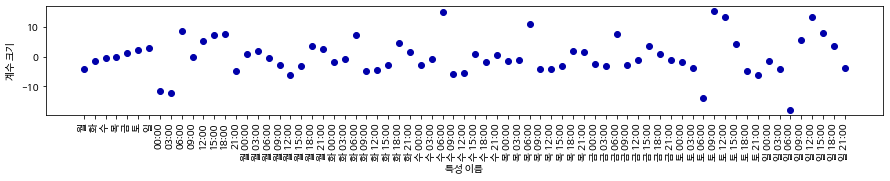

In [40]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["월", "화", "수", "목", "금", "토", "일"]
features =  day + hour

features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("특성 이름")
plt.ylabel("계수 크기")
plt.show()

# 교차검증(cross-validation)

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter=1000)

scores = cross_val_score(logreg, iris.data, iris.target)
print("교차 검증 점수:", scores)

교차 검증 점수: [0.967 1.    0.933 0.967 1.   ]


In [43]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=10)
print("교차 검증 점수:", scores)

교차 검증 점수: [1.    0.933 1.    1.    0.933 0.933 0.933 1.    1.    1.   ]


# 계층별 교차검증(stratifiedKFold)

In [54]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=3)
print("교차 검증 점수:\n",
      cross_val_score(logreg, iris.data, iris.target, cv=skfold))

교차 검증 점수:
 [0.98 0.96 0.98]


# K-Fold

In [55]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)
print("교차 검증 점수:\n",
      cross_val_score(logreg, iris.data, iris.target, cv=kfold))

교차 검증 점수:
 [0. 0. 0.]


In [56]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("교차 검증 점수:\n",
    cross_val_score(logreg, iris.data, iris.target, cv=kfold))

교차 검증 점수:
 [0.98 0.96 0.96]


# LOOCV(leave-one-out cross-validation)

In [44]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("교차 검증 분할 횟수: ", len(scores))
print("평균 정확도: {:.2f}".format(scores.mean()))

교차 검증 분할 횟수:  150
평균 정확도: 0.97


# 임의 분할 교차 검증(shuffle-split CV)

In [46]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("교차 검증 점수:\n", scores)
print("평균 정확도: {:.2f}".format(scores.mean()))

교차 검증 점수:
 [0.973 0.947 0.96  0.987 0.96  0.96  0.933 0.96  0.947 0.987]
평균 정확도: 0.96


In [47]:
from sklearn.model_selection import StratifiedShuffleSplit
shuffle_split = StratifiedShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("교차 검증 점수:\n", scores)
print("평균 정확도: {:.2f}".format(scores.mean()))

교차 검증 점수:
 [0.947 0.947 0.973 0.973 0.947 0.987 0.947 0.96  0.96  0.933]
평균 정확도: 0.96


# 그룹별 교차 검증

In [50]:
# 데이터 내에 연관된 그룹이 있는 경우
from sklearn.datasets import make_blobs
from sklearn.model_selection import GroupKFold
X, y = make_blobs(n_samples=12, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print("교차 검증 점수:\n", scores)
print("평균 정확도: {:.2f}".format(scores.mean()))
scores = cross_val_score(logreg, X, y, cv=3)
print("교차 검증 점수:", scores)
print("평균 정확도: {:.2f}".format(scores.mean()))

교차 검증 점수:
 [0.75  0.6   0.667]
평균 정확도: 0.67
교차 검증 점수: [0.75 0.75 0.75]
평균 정확도: 0.75


# Grid Search

In [65]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("훈련 세트의 크기: {}   테스트 세트의 크기: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가합니다
        score = svm.score(X_test, y_test)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("최고 점수: {:.2f}".format(best_score))
print("최적 파라미터:", best_parameters)

훈련 세트의 크기: 112   테스트 세트의 크기: 38
최고 점수: 0.97
최적 파라미터: {'C': 100, 'gamma': 0.001}


In [66]:
from sklearn.svm import SVC
# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("훈련 세트의 크기: {}   검증 세트의 크기: {}   테스트 세트의 크기:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 검증 세트로 SVC를 평가합니다
        score = svm.score(X_valid, y_valid)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후
# 테스트 세트를 사용해 평가합니다
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: ", best_parameters)
print("최적 파라미터에서 테스트 세트 점수: {:.2f}".format(test_score))

훈련 세트의 크기: 84   검증 세트의 크기: 28   테스트 세트의 크기: 38

검증 세트에서 최고 점수: 0.96
최적 파라미터:  {'C': 10, 'gamma': 0.001}
최적 파라미터에서 테스트 세트 점수: 0.92


# 교차검증을 사용한 그리드 서치

In [67]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        # 교차 검증을 적용합니다
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 교차 검증 정확도의 평균을 계산합니다
        score = np.mean(scores)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만듭니다
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: ", best_parameters)
print("최적 파라미터에서 테스트 세트 점수: {:.2f}".format(test_score))

검증 세트에서 최고 점수: 0.97
최적 파라미터:  {'C': 10, 'gamma': 0.1}
최적 파라미터에서 테스트 세트 점수: 0.97


# GridSearchCV

In [68]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
grid_search.fit(X_train, y_train)
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))
print("최적 매개변수:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))
print("최고 성능 모델:\n", grid_search.best_estimator_)

테스트 세트 점수: 0.97
최적 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 점수: 0.97
최고 성능 모델:
 SVC(C=10, gamma=0.1)


In [69]:
results = pd.DataFrame(grid_search.cv_results_)
display(np.transpose(results.head()))

,0,1,2,3,4
mean_fit_time,0.0016,0.0018,0.001,0.001,0.001
std_fit_time,0.00049,0.0004,6.8e-07,3.2e-07,2.8e-07
mean_score_time,0.0008,0.0008,0.0008,0.0002,0.0006
std_score_time,0.0004,0.0004,0.0004,0.0004,0.00049
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.35,0.35,0.35,0.35,0.35
split1_test_score,0.35,0.35,0.35,0.35,0.35
split2_test_score,0.36,0.36,0.36,0.36,0.36


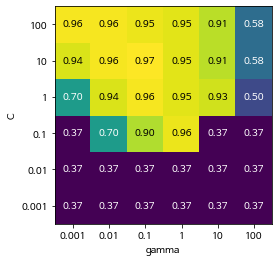

In [70]:
scores = np.array(results.mean_test_score).reshape(6, 6)
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
plt.show()

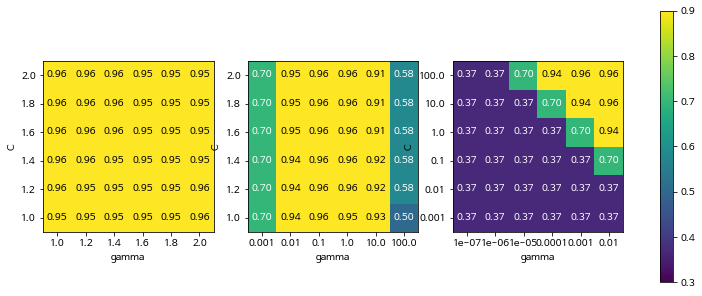

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                     'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # 교차 검증 평균 점수의 히트맵 그래프
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax, vmin=0.3, vmax=0.9)
    
plt.colorbar(scores_image, ax=axes.tolist())
plt.show()

# 비대칭 매개변수 그리드 탐색

In [72]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))
print("최적 매개변수:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))
print("최고 성능 모델:\n", grid_search.best_estimator_)

테스트 세트 점수: 0.97
최적 매개변수: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97
최고 성능 모델:
 SVC(C=10, gamma=0.1)


# 중첩교차검증

In [73]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("교차 검증 점수: ", scores)
print("교차 검증 평균 점수: ", scores.mean())

교차 검증 점수:  [0.967 1.    0.967 0.967 1.   ]
교차 검증 평균 점수:  0.9800000000000001


In [74]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # outer_cv의 분할을 순회하는 for 루프
    # (split 메소드는 훈련과 테스트 세트에 해당하는 인덱스를 리턴합니다)
    for training_samples, test_samples in outer_cv.split(X, y):
        # 최적의 매개변수를 찾습니다
        best_parms = {}
        best_score = -np.inf
        # 매개변수 그리드를 순회합니다
        for parameters in parameter_grid:
            # 안쪽 교차 검증의 점수를 기록합니다
            cv_scores = []
            # inner_cv의 분할을 순회하는 for 루프
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 훈련 데이터와 주어진 매개변수로 분류기를 만듭니다
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 검증 세트로 평가합니다
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 안쪽 교차 검증의 평균 점수를 계산합니다
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 점수가 더 높은면 매개변수와 함께 기록합니다
                best_score = mean_score
                best_params = parameters
        # 바깥쪽 훈련 데이터 전체를 사용해 분류기를 만듭니다
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 테스트 세트를 사용해 평가합니다
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [75]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("교차 검증 점수:", scores)

교차 검증 점수: [0.967 1.    0.967 0.967 1.   ]


# 불균형 데이터

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

In [3]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("예측된 레이블의 고유값:", np.unique(pred_most_frequent))
print("테스트 점수: {:.2f}".format(dummy_majority.score(X_test, y_test)))

예측된 레이블의 고유값: [False]
테스트 점수: 0.90


In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("테스트 점수: {:.2f}".format(tree.score(X_test, y_test)))

테스트 점수: 0.92


In [6]:
dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("예측된 레이블의 고유값:", np.unique(pred_dummy))
print("테스트 점수: {:.2f}".format(dummy.score(X_test, y_test)))

예측된 레이블의 고유값: [False  True]
테스트 점수: 0.81


In [7]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.1, max_iter=1000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg 점수: {:.2f}".format(logreg.score(X_test, y_test)))

logreg 점수: 0.98


# 오차행렬(confusion matrix)

In [8]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("오차 행렬:\n", confusion)

오차 행렬:
 [[402   1]
 [  6  41]]


In [15]:
print("빈도 기반 더미 모델:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\n무작위 더미 모델:")
print(confusion_matrix(y_test, pred_dummy))
print("\n결정 트리:")
print(confusion_matrix(y_test, pred_tree))
print("\n로지스틱 회귀")
print(confusion_matrix(y_test, pred_logreg))

빈도 기반 더미 모델:
[[403   0]
 [ 47   0]]

무작위 더미 모델:
[[359  44]
 [ 40   7]]

결정 트리:
[[390  13]
 [ 24  23]]

로지스틱 회귀
[[402   1]
 [  6  41]]


# F-score

In [16]:
from sklearn.metrics import f1_score
print("빈도 기반 더미 모델의 f1 score: {:.2f}".format(
    f1_score(y_test, pred_most_frequent)))
print("무작위 더미 모델의 f1 score: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("트리 모델의 f1 score: {:.2f}".format(f1_score(y_test, pred_tree)))
print("로지스틱 회귀 모델의 f1 score: {:.2f}".format(
    f1_score(y_test, pred_logreg)))

빈도 기반 더미 모델의 f1 score: 0.00
무작위 더미 모델의 f1 score: 0.14
트리 모델의 f1 score: 0.55
로지스틱 회귀 모델의 f1 score: 0.92


# Classification report

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent,
                            target_names=["9 아님", "9"]))

              precision    recall  f1-score   support

        9 아님       0.90      1.00      0.94       403
           9       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\Users\wkdwl\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wkdwl\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wkdwl\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(classification_report(y_test, pred_dummy,
                            target_names=["9 아님", "9"]))

              precision    recall  f1-score   support

        9 아님       0.90      0.89      0.90       403
           9       0.14      0.15      0.14        47

    accuracy                           0.81       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.82      0.81      0.82       450



In [19]:
print(classification_report(y_test, pred_logreg,
                            target_names=["9 아님", "9"]))

              precision    recall  f1-score   support

        9 아님       0.99      1.00      0.99       403
           9       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



# ROC/AUC

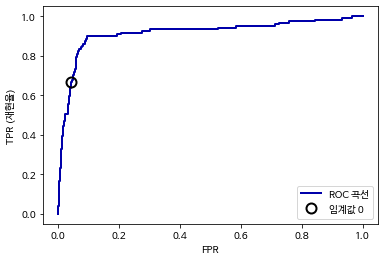

In [22]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC 곡선")
plt.xlabel("FPR")
plt.ylabel("TPR (재현율)")
# 0 근처의 임계값을 찾습니다
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="임계값 0", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show() # 책에는 없음

In [23]:
from sklearn.metrics import roc_auc_score
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("SVC의 AUC: {:.3f}".format(svc_auc))

SVC의 AUC: 0.916


# 모델 선택과 평가 지표

In [25]:
from sklearn.model_selection import cross_val_score
# 분류의 기본 평가 지표는 정확도 입니다
print("기본 평가 지표:",
      cross_val_score(SVC(), digits.data, digits.target == 9, cv=5))
# scoring="accuracy"의 결과와 같습니다.
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9,
                                     scoring="accuracy", cv=5)
print("정확도 지표:", explicit_accuracy)
ap =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="roc_auc", cv=5)
print("AUC 지표:", ap)

기본 평가 지표: [0.975 0.992 1.    0.994 0.981]
정확도 지표: [0.975 0.992 1.    0.994 0.981]
AUC 지표: [0.997 0.999 1.    1.    0.984]


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# 일부러 적절하지 않은 그리드를 만듭니다
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# 기본 정확도 측정 지표를 사용합니다
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("정확도 지표를 사용한 그리드 서치")
print("최적의 파라미터:", grid.best_params_)
print("최상의 교차 검증 점수 (정확도)): {:.3f}".format(grid.best_score_))
print("테스트 세트 정확도: {:.3f}".format(
      accuracy_score(y_test, grid.predict(X_test))))

정확도 지표를 사용한 그리드 서치
최적의 파라미터: {'gamma': 0.0001}
최상의 교차 검증 점수 (정확도)): 0.976
테스트 세트 정확도: 0.973


In [30]:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("AUC 지표를 사용한 그리드 서치")
print("최적의 파라미터:", grid.best_params_)
print("최상의 교차 검증 점수 (AUC): {:.3f}".format(grid.best_score_))
print("테스트 세트 정확도: {:.3f}".format(
      accuracy_score(y_test, grid.predict(X_test))))

AUC 지표를 사용한 그리드 서치
최적의 파라미터: {'gamma': 0.01}
최상의 교차 검증 점수 (AUC): 0.998
테스트 세트 정확도: 0.896
